# Carga de librerías

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from pandas import DataFrame , read_csv , concat
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import subplots , show
import numpy as np

# Pretratamiento de datos

## Carga de datos

In [2]:
FILE_NAME = 'airbnb.csv' ;
df_raw = read_csv(FILE_NAME ) ;
df_raw.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11547,https://www.airbnb.com/rooms/11547,20200919153121,2020-09-21,My home at the beach,"Sun, joy, relax, quality, beach & peace.<br />...",NaN,https://a0.muscache.com/pictures/494126/8c151b...,42942,https://www.airbnb.com/users/show/42942,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.93
1,100831,https://www.airbnb.com/rooms/100831,20200919153121,2020-09-21,HOUSE IN MALLORCA - WiFi(ET-3045),<b>The space</b><br />House situated in a quie...,NaN,https://a0.muscache.com/pictures/675527/72b329...,529151,https://www.airbnb.com/users/show/529151,...,10.0,10.0,10.0,ETV-3045,t,1,1,0,0,1.47


## Eliminación de columnas con excesivos valores nulos

In [3]:
print('Num de columnas del dataset original : %d' % ( df_raw.shape[1] ) ) ;
filtered_columns = df_raw.isna().sum() < 10 ;
df_filtered_cols = df_raw.loc[ : , filtered_columns ]
print('Num de columnas eliminadas : %d' % ( df_raw.shape[1] - df_filtered_cols.shape[1] ) ) ;

Num de columnas del dataset original : 74
Num de columnas eliminadas : 25


## Eliminación de filas con valores nulos

In [4]:
print('Num total de filas : %d' % ( df_filtered_cols.shape[0] ) ) ;
df_filtered_rows = df_filtered_cols.dropna( axis = 0 , how = 'any' ) ;
df_filtered_rows = df_filtered_rows.reset_index( drop = True ) ; 
print('Num de filas eliminadas : %d' % ( df_filtered_cols.shape[0] - df_filtered_rows.shape[0] ) ) ;

Num total de filas : 17608
Num de filas eliminadas : 11


## Filtrado de columnas numéricas relevantes

In [5]:
num_cols = df_filtered_rows.select_dtypes( include = np.number ).columns ;
unique_values = df_filtered_rows[ num_cols ].apply( lambda col : col.unique().shape[0] ) ;

bad_num_cols = unique_values[ ( unique_values == 1 ) | ( unique_values == df_filtered_rows.shape[0] ) ].index ;
df_num_col_filtered = df_filtered_rows.drop( bad_num_cols , axis = 1 ) ;

print('Num total de columnas : %d' % ( df_num_col_filtered.shape[1] ) ) ;
print('Num de columnas eliminadas : %d' % ( bad_num_cols.shape[0] ) ) ;

Num total de columnas : 47
Num de columnas eliminadas : 2


## Filtrado de columnas no numericas relevantes

In [6]:
non_num_cols = df_num_col_filtered.columns.difference( num_cols ) ;
unique_values = df_num_col_filtered[ non_num_cols ].apply( lambda col : col.unique().shape[0] ) ;
bad_str_cols = unique_values[ ( unique_values == 1 ) | (unique_values > 100 ) ].index ;
df_str_col_filtered = df_num_col_filtered.drop( bad_str_cols , axis = 1 ) ;
print('Num total de columnas : %d' % ( df_str_col_filtered.shape[1] ) ) ;
print('Num de columnas no numericas eliminadas : %d' % ( bad_str_cols.shape[0] ) ) ;

Num total de columnas : 36
Num de columnas no numericas eliminadas : 11


## Conversión de la columna de precio a numerico

In [7]:
df_with_price = df_str_col_filtered.copy();
df_with_price['price'] = df_raw['price'].apply( lambda price : float(price.strip( '$' ).replace(',','')) ) ;
df_with_price.head(2)

,last_scraped,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,...,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,price
0,2020-09-21,42942,f,0.0,0.0,t,t,Calvià,39.51888,2.48182,...,2020-09-21,103,8,2,f,1,1,0,0,89.0
1,2020-09-21,529151,f,1.0,1.0,t,t,Santa Margalida,39.76347,3.16255,...,2020-09-21,30,13,0,t,1,1,0,0,175.0


## Conversión de columnas no numericas a categoricas

In [8]:
df_formated = df_with_price.copy() ;
num_cols = df_with_price.select_dtypes( include = np.number ).columns ;
non_num_cols = [ col for col in df_with_price.columns if col not in num_cols ] ;

df_formated[ non_num_cols ] = df_with_price[ non_num_cols ].apply( lambda col : col.astype('category').cat.codes ) ;
df_formated.head(2)

,last_scraped,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,...,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,price
0,2,42942,0,0.0,0.0,1,1,10,39.51888,2.48182,...,2,103,8,2,0,1,1,0,0,89.0
1,2,529151,0,1.0,1.0,1,1,42,39.76347,3.16255,...,2,30,13,0,1,1,1,0,0,175.0


## Búsqueda de colinealidad con el precio

In [9]:
df_price_corr = df_formated.corr()['price'] ;
df_price_corr = df_price_corr.drop('price') ;
df_price_corr = df_price_corr.abs() * 100 ;
threshold = 1.4 ;
most_correlated_cols = df_price_corr[ df_price_corr > threshold ].index.values.tolist() ;
df_most_corr = df_formated[ most_correlated_cols + [ 'price' ] ] ;

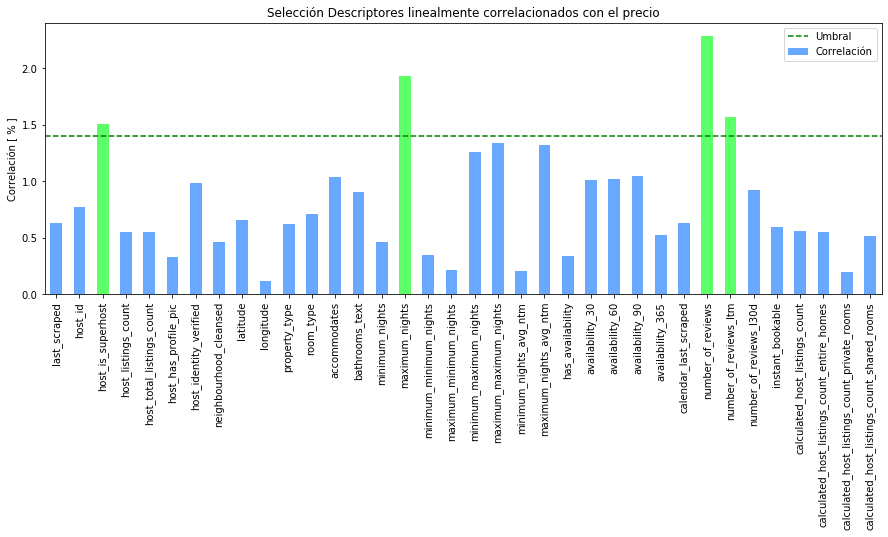

In [10]:
bar_colors = ['#5CFF68' if(col in most_correlated_cols) else '#68A8FF'  for col in df_price_corr.index.tolist() ] ;
ax = df_price_corr.plot.bar( figsize = ( 15 , 5 ) , color = bar_colors , label = 'Correlación' ) ;
ax.axhline( threshold , linestyle = '--' , color = 'green' , label = 'Umbral' ) ;
ax.set_title( 'Selección Descriptores linealmente correlacionados con el precio' ) ;
ax.set_ylabel( 'Correlación [ % ]' ) ;
ax.legend();
show();

## Eliminado de valores atípicos

In [11]:
non_outlier_idx = ( ( df_most_corr['price'].mean() - df_most_corr['price'] ) / df_most_corr['price'].std() ).abs() < 3
df_final = df_most_corr[ non_outlier_idx ] ;
df_final.head( 4 )

,host_is_superhost,maximum_nights,number_of_reviews,number_of_reviews_ltm,price
0,0,60,103,8,89.0
1,0,365,30,13,175.0
2,1,365,14,0,140.0
3,0,365,9,0,200.0


## Normalización de los datos

In [12]:
input_scaler = MinMaxScaler( feature_range = ( 0 , 1 ) ) ;
output_scaler = MinMaxScaler( feature_range = ( 0 , 1 ) ) ;

input_cols = df_final.columns.difference( [ 'price' ] ) ;

inputs = input_scaler.fit_transform( df_final[ input_cols ] ) ;
outputs = output_scaler.fit_transform( df_final[ [ 'price' ] ] ) ;

DataFrame( np.hstack( [ inputs , outputs ] ) , columns = df_final.columns ).head( 4 )

,host_is_superhost,maximum_nights,number_of_reviews,number_of_reviews_ltm,price
0,0.0,0.016862,0.198077,0.108108,0.061084
1,0.0,0.104030,0.057692,0.175676,0.120110
2,1.0,0.104030,0.026923,0.000000,0.096088
3,0.0,0.104030,0.017308,0.000000,0.137268


## Separación de datos en datos de entrenamiento y test

In [13]:
x_train, x_test, y_train, y_test = train_test_split( inputs , outputs , test_size = 0.2 , random_state = 0 ) ;

y_test_real = output_scaler.inverse_transform(y_test) ;

# Creación de modelos

## Árbol de decisión de Regresión

### Creación del Modelo

In [14]:
param_grid = { 'criterion' : [ 'mse' , 'friedman_mse' , 'mae' ] , 'splitter' : [ 'best' , 'random' ] } ;

decision_tree_models = GridSearchCV(
    DecisionTreeRegressor() , param_grid ,
    scoring = 'neg_mean_squared_error' , cv = 5 ) ;

### Entrenamiento del Modelo

In [15]:
decision_tree_models.fit( x_train , y_train ) ;

### Test del Modelo

In [16]:
decision_tree_best_model = decision_tree_models.best_estimator_ ;
y_test_pred = decision_tree_best_model.predict( x_test ).reshape( -1 , 1 ) ;

y_test_pred_real = output_scaler.inverse_transform( y_test_pred ) ;
abs_error = abs( y_test_real - y_test_pred_real ) ;

data = [ mean_squared_error( y_test , y_test_pred ) , abs_error.min() , abs_error.max() , abs_error.mean() ] ;
df_decision_tree = DataFrame( data , columns = ['Modelo Árbol de Decisión'] , index = ['MSE','Error Abs Mín' , 'Error Abs Máx','Error Medio']) ;
df_decision_tree

,Modelo Árbol de Decisión
MSE,0.018778
Error Abs Mín,0.000000
Error Abs Máx,1198.390236
Error Medio,135.593879


## Random Forest de Regresión

### Creación del Modelo

In [17]:
param_grid = { 'n_estimators' : [ 40 , 50 , 60 , 70] , 'criterion' : [ 'mse' ] } ;

random_forest_models = GridSearchCV(
    RandomForestRegressor() , param_grid ,
    scoring = 'neg_mean_squared_error' , cv = 2 ) ;

### Entrenamiento del Modelo

In [18]:
random_forest_models.fit( inputs, outputs.reshape( -1 , ) ) ;

### Test del Modelo

In [19]:
random_forest_best_model = random_forest_models.best_estimator_ ;
y_test_pred = random_forest_best_model.predict( x_test ).reshape( -1 , 1 ) ;

y_test_pred_real = output_scaler.inverse_transform( y_test_pred ) ;
abs_error = abs( y_test_real - y_test_pred_real ) ;

data = [ mean_squared_error( y_test , y_test_pred ) , abs_error.min() , abs_error.max() , abs_error.mean() ] ;
df_random_forest = DataFrame( data , columns = ['Modelo de Random Forest'] , index = ['MSE','Error Abs Mín' , 'Error Abs Máx','Error Medio']) ;
df_random_forest

,Modelo de Random Forest
MSE,0.012031
Error Abs Mín,0.018880
Error Abs Máx,1197.981120
Error Medio,106.015455


## Regresión Lineal

### Creación del Modelo

In [20]:
linear_reg_model = LinearRegression() ;

### Entrenamiento del Modelo

In [21]:
linear_reg_model.fit( x_train , y_train ) ;

### Test del Modelo

In [22]:
y_test_pred = linear_reg_model.predict( x_test ).reshape( -1 , 1 ) ;

y_test_pred_real = output_scaler.inverse_transform( y_test_pred ) ;
abs_error = abs( y_test_real - y_test_pred_real ) ;

data = [ mean_squared_error( y_test , y_test_pred ) , abs_error.min() , abs_error.max() , abs_error.mean() ] ;
df_lin_reg = DataFrame( data , columns = ['Modelo de Regresión Lineal'] , index = ['MSE','Error Abs Mín' , 'Error Abs Máx','Error Medio']) ;
df_lin_reg

,Modelo de Regresión Lineal
MSE,0.014724
Error Abs Mín,0.056737
Error Abs Máx,1202.642769
Error Medio,120.272354


# Comparativa entre modelos

In [23]:
concat( [ df_decision_tree , df_random_forest , df_lin_reg ] , axis = 1 )

,Modelo Árbol de Decisión,Modelo de Random Forest,Modelo de Regresión Lineal
MSE,0.018778,0.012031,0.014724
Error Abs Mín,0.000000,0.018880,0.056737
Error Abs Máx,1198.390236,1197.981120,1202.642769
Error Medio,135.593879,106.015455,120.272354
